<H1>Klasyfikacja za pomocą metod minimalno-odległościowych</H1>

<H3>Ćwiczenie 1</H3>

Celem ćwiczenia jest:
- utworzenie reprezentacji zbioru danych - przekształcenie obrazu na wektor cech;
- zastosowanie metod minimalnoodległościowych do klasyfikacji.
- wizualizacja wyników klasyfikatora

___

Wczytywanie danych

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import csv

# function for reading the images
# arguments: path to the traffic sign data, for example './GTSRB/Training'
# returns: list of images, list of corresponding labels 
def readTrafficSigns(rootpath):
    '''Reads traffic sign data for German Traffic Sign Recognition Benchmark.

    Arguments: path to the traffic sign data, for example './GTSRB/Training'
    Returns:   list of images, list of corresponding labels'''
    images = [] # images
    labels = [] # corresponding labels
    # loop over all 42 classes
    for c in range(0,43):
        prefix = rootpath + '/' + format(c, '05d') + '/' # subdirectory for class
        gtFile = open(prefix + 'GT-'+ format(c, '05d') + '.csv') # annotations file
        gtReader = csv.reader(gtFile, delimiter=';') # csv parser for annotations file
        next(gtReader) # skip header !!!!!!!!!!!!!!!!!!TUTAJ NALEŻY KONIECZKIE ZMIENIĆ ORYGINAŁ
        # loop over all images in current annotations file
        for row in gtReader:
            x1,y1,x2,y2 = map(int,row[3:7])
            images.append(np.array(plt.imread(prefix + row[0]))[y1:y2,x1:x2]) # the 1th column is the filename
            labels.append(int(row[7])) # the 8th column is the label# TU ZMIENIĆ ODROBINKĘ
        gtFile.close()
    return np.array(images), np.array(labels)# I TU JESZCZE TROCHĘ

Wczytanie danych z folderu

In [33]:
path = '/home/justyna/Desktop/SEMESTR2/PUM/MachineLearning/GTSRB/Final_Training/Images'
images, labels = readTrafficSigns(path)

Utworzenie wektora etykiet zawierającego podział na grupy znaków, zamiast podziału na podtypy.

In [34]:
class_names=["zakazu", "ostrzegawcze", "informacyjne", "nakazu"]
sign_groups = [0,0,0,0,0,0,0,0,0,0,0,1,2,1,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,3,3,3,3,3,3,3,3,0,0]
labels_groups = np.array([sign_groups[cls] for cls in labels])

Wybranie elementu przykładowego w celu pokazania naiwnej reprezentacji danych

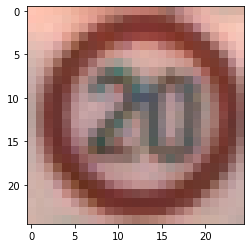

In [35]:
plt.figure()
plt.imshow(images[100])
plt.show()

Naiwna reprezentacja poprzez sumowanie składowych RGB, anastępnie wyznaczenie ich wzajemnej relacji

In [36]:
img=images[100]
features=np.array([np.sum(img[:,:,0]),np.sum(img[:,:,1]),np.sum(img[:,:,2])])
features=features/np.sum(features)
features

array([0.41163983, 0.30225772, 0.28610245])

Wyznaczenie nowej reprezentacji elementów<br>
Podział zbioru na testowy i treningowy


In [37]:
from sklearn.model_selection import train_test_split
training_set, test_set, training_labels, test_labels = train_test_split(images, labels, test_size=0.33, random_state=3)

Zdefiniowanie funkcji pozwalającej na przekształcenie obrazu na wektor cech.

In [38]:
def convertToRelativeRGB(arr):
    result = [np.array([np.sum(img[:,:,0]),np.sum(img[:,:,1]),np.sum(img[:,:,2])]) for img in arr ]
    result = result/np.sum(result,axis=1)[:,None]
    return result

In [39]:
image_features = convertToRelativeRGB(images)
training_vec = convertToRelativeRGB(training_set)
test_vec = convertToRelativeRGB(test_set)

In [40]:
print(np.shape(training_vec))
print(np.shape(test_vec))

(26270, 3)
(12939, 3)


In [41]:
print(training_vec[1])

[0.39512004 0.30930618 0.29557378]


Klasyfikacja za pomocą kNN

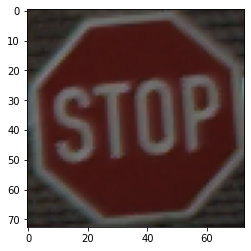

In [35]:
tested_case = 14

plt.figure()
plt.imshow(test_set[tested_case])

Klasyfikacja za pomoca metody kNN:
- utworzenie wektora odległości pomiędzy naszą próbką (tested_case) oraz wszystkimi próbkami w zbiorze treningowym
```python
distances_vec = np.sum((np.tile(test_vec[tested_case],(np.shape(training_vec)[0],1)) - training_vec)**2, axis=1)
```
- posortowanie indeksów wektora odległości, i wybranie k najbliższych obiektów
```python
sorted_indices = np.argsort( distances_vec )[:k].astype(int)
```
- sprawdzenie etykiet najbliższych sąsiadów
```python
nearest_neighbours = np.array(training_labels)[sorted_indices]
```

In [36]:
k = 3
distances_vec = np.sum((np.tile(test_vec[tested_case],(np.shape(training_vec)[0],1)) - training_vec)**2, axis=1)
sorted_indices = np.argsort( distances_vec )[:k].astype(int)                              
nearest_neighbours = np.array(training_labels)[sorted_indices]

#poniżej to samo w jednej linii
#nearest_neighbours = np.array(training_labels)[np.argsort(np.sum((np.tile(test_vec[tested_case],(np.shape(training_vec)[0],1)) - training_vec)**2, axis=1))[:k].astype(int)]
print(nearest_neighbours)
max(set(nearest_neighbours), key=list(nearest_neighbours).count)

[17 14 14]


14

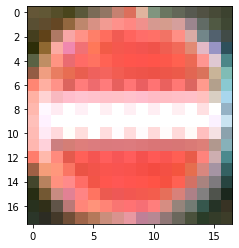

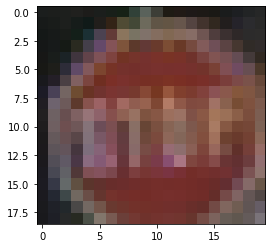

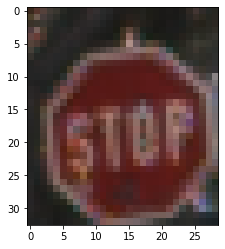

In [37]:
k = 3
nearest_neighbours = np.array(training_set)[np.argsort(np.sum((np.tile(test_vec[tested_case],(np.shape(training_vec)[0],1)) - training_vec)**2, axis=1))[:k].astype(int)]

for img in nearest_neighbours:
    plt.figure()
    plt.imshow(img)
    plt.show()


Wykorzystanie biblioteki scipy do klasyfikcji za pomocą kNN

In [38]:
from sklearn.neighbors import KNeighborsClassifier

In [39]:
training_set_g, test_set_g, training_labels_g, test_labels_g = train_test_split(image_features, labels_groups, test_size=0.33, random_state=3)

Utworzenie modelu klasyfikatora kNN, k=3. <br>
"Dopasowanie" danych treningowych - zapisanie ich w modelu.<br>
Wykorzystanie klasyfikatora do etykietowanie danych testowych.

In [40]:
classifier = KNeighborsClassifier(n_neighbors=3)
classifier.fit(training_set_g, training_labels_g) 
predicted_groups = classifier.predict(test_set_g)

In [41]:
print(predicted_groups[:30])
print(test_labels_g[:30])

[3 0 0 0 0 0 0 3 0 1 1 1 0 0 0 0 0 1 1 0 0 0 0 0 1 3 0 0 3 1]
[3 0 0 1 1 0 0 3 0 0 0 1 0 1 0 0 0 0 1 0 0 1 1 0 0 3 3 0 3 1]


Macierz błędów (tablica pomyłek)

In [42]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [43]:
confusion_matrix(test_labels_g, predicted_groups)

array([[5045, 1430,  104,  104],
       [2035, 1516,   74,   67],
       [ 255,  177,  215,   40],
       [ 257,  107,   15, 1498]])

Można użyć również biblioteki pandas, która pozwala wyświetlić dane w formie tabeli.

In [44]:
import pandas as pd
actual_series = pd.Series(test_labels_g, name='Actual')
predicted_series = pd.Series(predicted_groups, name='Predicted')
df_confusion = pd.crosstab(actual_series, predicted_series)
df_confusion

Predicted,0,1,2,3
Actual,,,,
0,5045,1430,104,104
1,2035,1516,74,67
2,255,177,215,40
3,257,107,15,1498


Analiza poprawności zaklasyfikowania jednej grupy znaków na przykładzie znaków ostrzegawczych

In [45]:
#znaki ostrzegawcze były oznaczone etykietą 1 
test_labels_g[test_labels_g!=1]=0 #zmiana wszystkich etykiet innych niż 1 na 0
predicted_groups[predicted_groups!=1]=0

In [46]:
print(predicted_groups[:30])
print(test_labels_g[:30])

[0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 1]
[0 0 0 1 1 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 1]


Ile obiektów ze zbioru testowego zostało poprawnie zaklasyfikowanych?

In [47]:
accuracy_score(test_labels_g, predicted_groups, normalize=True)

0.6993585284797897

In [48]:
np.sum(test_labels_g==0)

9247

In [49]:
np.sum(test_labels_g==1)

3692

In [50]:
np.sum(test_labels_g==0)/len(test_labels_g)

0.7146611020944431

Który klasyfikator jest lepszy?<br>
Klasyfikujący 55% danych poprawnie czy klasyfikujący 71% danych poprawnie?

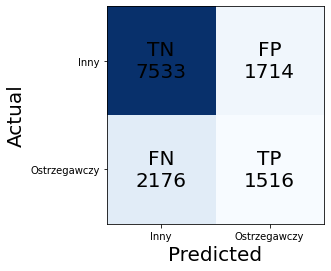

In [51]:
plt.figure()
cm=confusion_matrix(test_labels_g, predicted_groups)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.xlabel("Predicted", fontsize=20)
plt.ylabel("Actual", fontsize=20)
plt.xticks([0,1], ('Inny', 'Ostrzegawczy'))
plt.yticks([0,1], ('Inny', 'Ostrzegawczy'))
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+"\n"+str(cm[i][j]), fontsize=20, verticalalignment='center', horizontalalignment='center')

In [52]:
tn, fp, fn, tp = confusion_matrix(test_labels_g, predicted_groups).ravel()

Czułość - TPR (True Positive Rate), sensitivity, recall

$ TPR = P(y_{predicted}=true/y_{actual}=true) = \frac{TP}{TP+FN} $

In [53]:
TPR=tp/(tp+fn)
TPR

0.4106175514626219

Swoistość - TNR (True Negative Rate), specificity, selectivity

$ TNR = P(y_{predicted}=false/y_{actual}=false) = \frac{TN}{TN+FP} $

In [54]:
TNR=tn/(tn+fp)
TNR

0.8146425867849032

___

Reprezentacja przestrzeni cech na płaszczyźnie za pomoca TSNE

In [55]:
import random
image_features = convertToRelativeRGB(images)
random_indices = np.array(random.sample(range(len(image_features)), 1000))
image_features[random_indices]

array([[0.39728092, 0.30353154, 0.29918754],
       [0.36304175, 0.32015441, 0.31680385],
       [0.45350911, 0.2867497 , 0.25974119],
       ...,
       [0.39632532, 0.30309135, 0.30058333],
       [0.2999882 , 0.32823325, 0.37177855],
       [0.37711308, 0.29833003, 0.32455689]])

In [56]:
from sklearn.manifold import TSNE
model = TSNE(learning_rate=100)
transformed = model.fit_transform(image_features[random_indices])

xs=transformed[:,0]
ys=transformed[:,1]

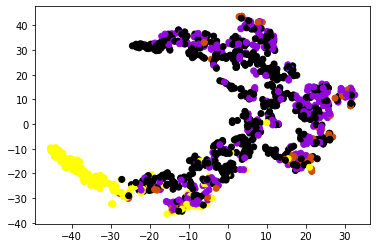

In [57]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

x = transformed[:,0]
y = transformed[:,1]
images_array = images[random_indices]

fig = plt.figure()
ax = fig.add_subplot(111)

cmap = plt.get_cmap('gnuplot')
#colors = [cmap(i/42) for i in labels[random_indices]]
colors = [cmap(i/3) for i in labels_groups[random_indices]]

line = ax.scatter(x,y, marker="o", color=colors)

im = OffsetImage(images_array[0], zoom=5)
xybox=(50., 50.)
ab = AnnotationBbox(im, (0,0), xybox=xybox, xycoords='data',
        boxcoords="offset points",  pad=0.3,  arrowprops=dict(arrowstyle="->"))

ax.add_artist(ab)
ab.set_visible(False)

def hover(event):
    # if the mouse is over the scatter points
    if line.contains(event)[0]:
        # find out the index within the array from the event
        ind = line.contains(event)[1]["ind"][0]
        # get the figure size
        w,h = fig.get_size_inches()*fig.dpi
        ws = (event.x > w/2.)*-1 + (event.x <= w/2.) 
        hs = (event.y > h/2.)*-1 + (event.y <= h/2.)
        # if event occurs in the top or right quadrant of the figure,
        # change the annotation box position relative to mouse.
        ab.xybox = (xybox[0]*ws, xybox[1]*hs)
        # make annotation box visible
        ab.set_visible(True)
        # place it at the position of the hovered scatter point
        ab.xy =(x[ind], y[ind])
        # set the image corresponding to that point
        im.set_data(images_array[ind])
    else:
        #if the mouse is not over a scatter point
        ab.set_visible(False)
    fig.canvas.draw_idle()

# add callback for mouse moves
fig.canvas.mpl_connect('motion_notify_event', hover)           
plt.show()

In [58]:
%matplotlib inline

<H3>Ćwiczenie zaliczeniowe<H3>

Celem ćwiczenia jest:
- przećwiczenie wiedzy o klasyfikatorach

Zadanie:

Część 1:
- pobierz bazę danych covertype (https://archive.ics.uci.edu/ml/datasets/Covertype)  
należy wykorzystać funkcję: https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_covtype.html
- zwizualizuj dane przy użyciu TSNE
- napisz własna implementację klasyfikatora kNN
- naucz klasyfikator kNN
- naucz KNeighborsClassifier ze scikit-learn
- przeanalizuj i porównaj wyniki klasyfikatorów (confusion matrix, wykres k vs accuracy)
- napisz własną implementację klasyfikatora kNM
- naucz klasyfikator kNM
- porównaj accuracy własnego kNM z obiema wersjami kNN
- porównaj zużycie pamięci obu typów klasyfikacji

Część 2:
- wykorzystując bazę danych GTSRB zbuduj własną reprezentację danych o znakach (własny wektor cech, minimum 5 cech)
- zwizualizuj dane przy użyciu TSNE
- w oparciu o stworzony zestaw cech porównaj klasyfikatory z części 1

___

In [18]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import sklearn.datasets
from sklearn.model_selection import train_test_split
import numpy
import math
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

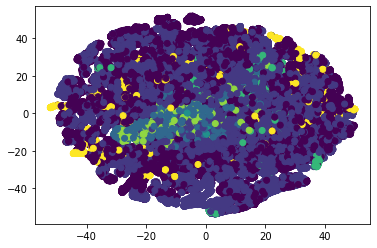

In [62]:
plt.figure()
plt.scatter(xs,ys,c=training_labels)
plt.show()